<a href="https://www.kaggle.com/code/ltrahul/tabular-playground-jun-2022-simple-explanation?scriptVersionId=118425935" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-jun-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-jun-2022/data.csv


In [2]:
input_path = Path('/kaggle/input/tabular-playground-series-jun-2022/')
data = pd.read_csv(input_path / 'data.csv', index_col='row_id')
submission = pd.read_csv(input_path / 'sample_submission.csv', index_col='row-col')

## Data Exploration

### Which columns have missing values?

Everything except the F_2_* columns (int64 columns)

In [3]:
data.columns

Index(['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6', 'F_1_7',
       'F_1_8', 'F_1_9', 'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14',
       'F_2_0', 'F_2_1', 'F_2_2', 'F_2_3', 'F_2_4', 'F_2_5', 'F_2_6', 'F_2_7',
       'F_2_8', 'F_2_9', 'F_2_10', 'F_2_11', 'F_2_12', 'F_2_13', 'F_2_14',
       'F_2_15', 'F_2_16', 'F_2_17', 'F_2_18', 'F_2_19', 'F_2_20', 'F_2_21',
       'F_2_22', 'F_2_23', 'F_2_24', 'F_3_0', 'F_3_1', 'F_3_2', 'F_3_3',
       'F_3_4', 'F_3_5', 'F_3_6', 'F_3_7', 'F_3_8', 'F_3_9', 'F_3_10',
       'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14', 'F_3_15', 'F_3_16', 'F_3_17',
       'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21', 'F_3_22', 'F_3_23', 'F_3_24',
       'F_4_0', 'F_4_1', 'F_4_2', 'F_4_3', 'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7',
       'F_4_8', 'F_4_9', 'F_4_10', 'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 80 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   F_1_0   981603 non-null   float64
 1   F_1_1   981784 non-null   float64
 2   F_1_2   981992 non-null   float64
 3   F_1_3   981750 non-null   float64
 4   F_1_4   981678 non-null   float64
 5   F_1_5   981911 non-null   float64
 6   F_1_6   981867 non-null   float64
 7   F_1_7   981872 non-null   float64
 8   F_1_8   981838 non-null   float64
 9   F_1_9   981751 non-null   float64
 10  F_1_10  982039 non-null   float64
 11  F_1_11  981830 non-null   float64
 12  F_1_12  981797 non-null   float64
 13  F_1_13  981602 non-null   float64
 14  F_1_14  981961 non-null   float64
 15  F_2_0   1000000 non-null  int64  
 16  F_2_1   1000000 non-null  int64  
 17  F_2_2   1000000 non-null  int64  
 18  F_2_3   1000000 non-null  int64  
 19  F_2_4   1000000 non-null  int64  
 20  F_2_5   1000000 non-null 

### Frequency plot of missing values across rows

<AxesSubplot:ylabel='Missing value count'>

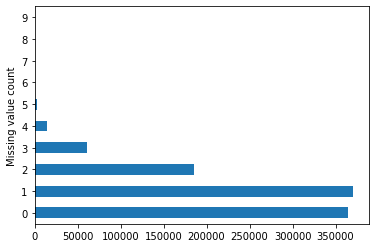

In [5]:
pd.DataFrame(data.isnull().sum(axis=1), columns = ['Missing value count']).reset_index().groupby('Missing value count').row_id.count().plot(kind='barh')

### Approximately 1-2% of data missing in each column

In [6]:
pd.options.display.float_format = '{:,.2f} %'.format
(data.isnull().sum()/len(data))*100

F_1_0    1.84 %
F_1_1    1.82 %
F_1_2    1.80 %
F_1_3    1.82 %
F_1_4    1.83 %
          ...  
F_4_10   1.82 %
F_4_11   1.81 %
F_4_12   1.83 %
F_4_13   1.80 %
F_4_14   1.83 %
Length: 80, dtype: float64

In [7]:
pd.options.display.float_format = '{:,.2f}'.format

### Which features are correlated with each other?

1. F_2 features are only correlated with F_2 features, so we can't use them to predict any other features. Since they don't have missing values as well, the assumption is to ignore them.
2. F_4 features are correlated with F_4 features , so we can use them to find missing values in F_4 using regression
3. F_1 and F_3 have 0 correlation with any other features, so we need to resort to mean imputation

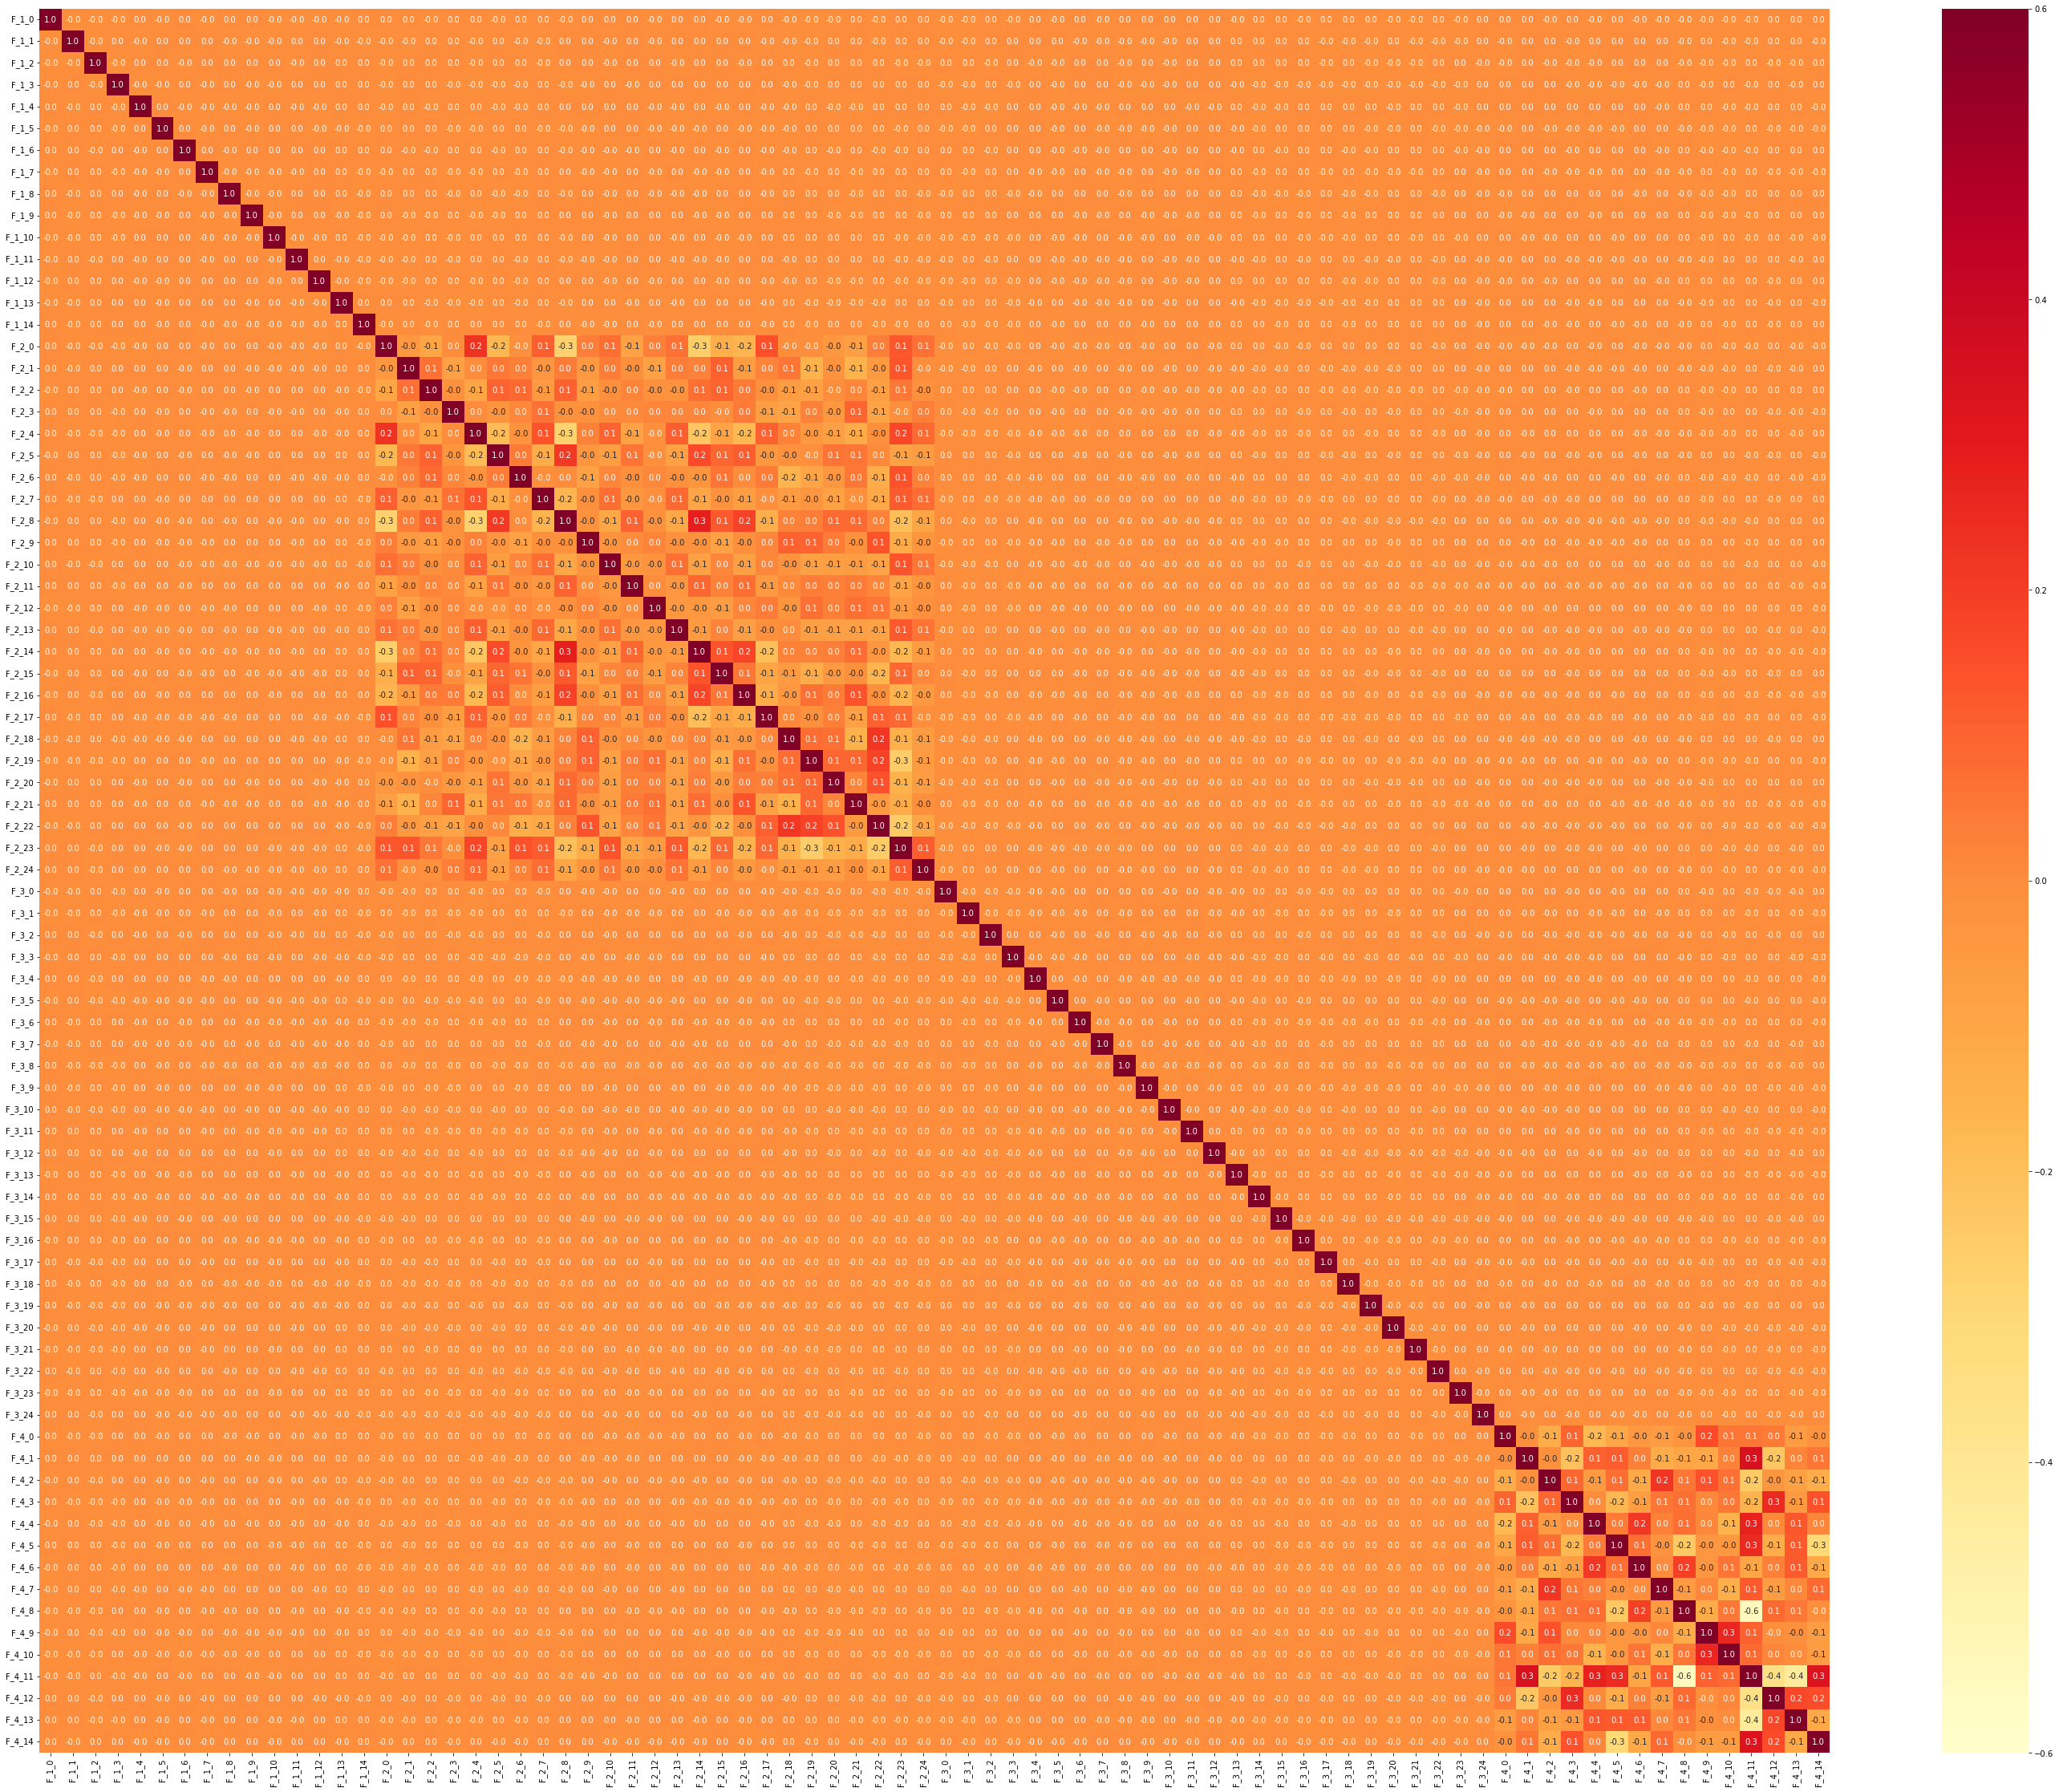

In [8]:
data_corr = data.corr()
plt.subplots(figsize=(50,40))
sns.heatmap(data_corr, annot= True, cmap="YlOrRd", fmt = '0.1f', vmin=-0.6, vmax=0.6);

### Data distribution of the continuous variables - using boxplot

Acknowledgement : https://www.kaggle.com/code/dhirajkumar612/iterative-imputer-linear-regression

In [9]:
columns_with_correlations = ['F_4_0', 'F_4_1', 'F_4_2', 'F_4_3',
       'F_4_4', 'F_4_5', 'F_4_6', 'F_4_7', 'F_4_8', 'F_4_9', 'F_4_10',
       'F_4_11', 'F_4_12', 'F_4_13', 'F_4_14']

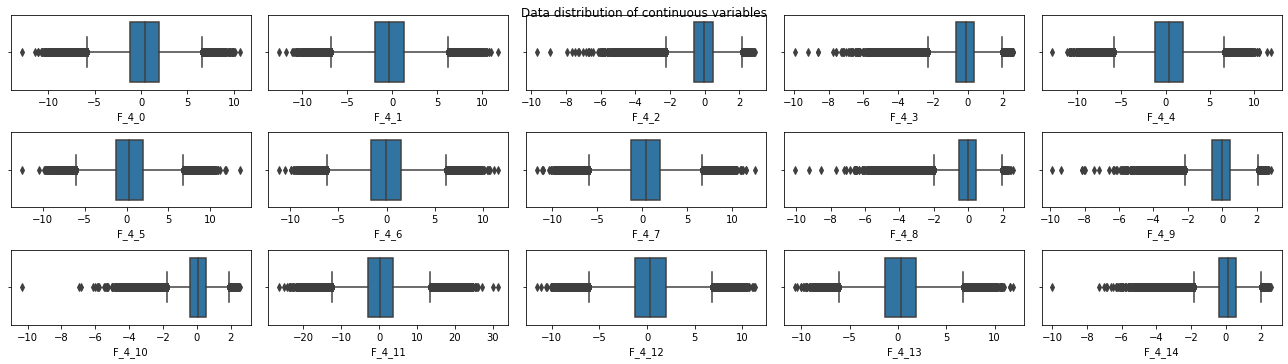

In [10]:
plt.figure(figsize=(18, 18))
for i, col in enumerate(columns_with_correlations): 
    ax = plt.subplot(11,5, i+1) 
    sns.boxplot(data=data[columns_with_correlations],x=col,ax=ax)
plt.suptitle('Data distribution of continuous variables')
plt.tight_layout()                    

### Power transformation

We see that some data is skewed to the left with outliers from the box plot above. Power transformation can help. A power transform will make the probability distribution of a variable more Gaussian.

In [11]:
from sklearn.preprocessing import PowerTransformer
power = PowerTransformer(method='yeo-johnson', standardize=False)
f4_data = pd.DataFrame( power.fit_transform(data[columns_with_correlations]),columns = columns_with_correlations)

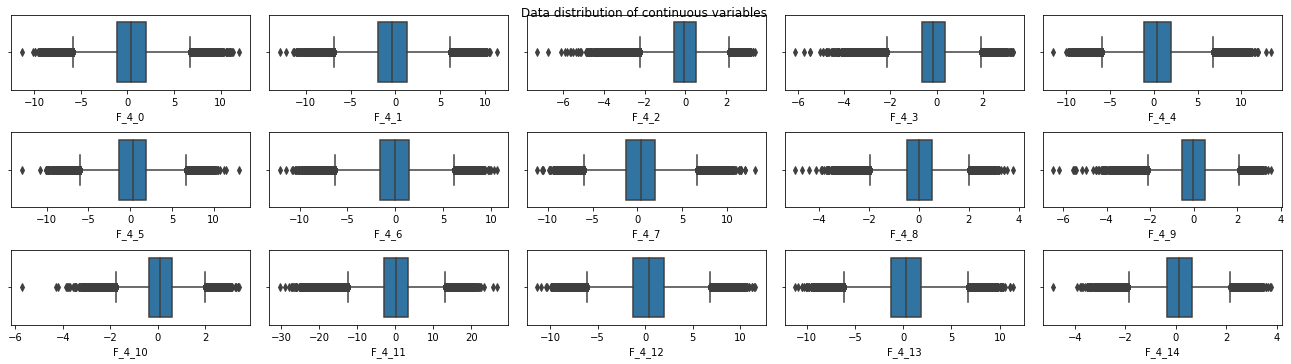

In [12]:
plt.figure(figsize=(18, 18))
for i, col in enumerate(columns_with_correlations): 
    ax = plt.subplot(11,5, i+1) 
    sns.boxplot(data=f4_data,x=col,ax=ax)
plt.suptitle('Data distribution of continuous variables')
plt.tight_layout()                    

## Strategy to identify missing values

Let's use mean imputation for F_1 and F_3 features and XgBoost based regression imputer for F_4 features. 

### Mean Imputation

In [13]:
columns_to_mean_impute = ['F_1_0', 'F_1_1', 'F_1_2', 'F_1_3', 'F_1_4', 'F_1_5', 'F_1_6', 'F_1_7',
       'F_1_8', 'F_1_9', 'F_1_10', 'F_1_11', 'F_1_12', 'F_1_13', 'F_1_14',
       'F_3_0', 'F_3_1', 'F_3_2', 'F_3_3', 'F_3_4', 'F_3_5', 'F_3_6', 'F_3_7',
       'F_3_8', 'F_3_9', 'F_3_10', 'F_3_11', 'F_3_12', 'F_3_13', 'F_3_14',
       'F_3_15', 'F_3_16', 'F_3_17', 'F_3_18', 'F_3_19', 'F_3_20', 'F_3_21',
       'F_3_22', 'F_3_23', 'F_3_24']

In [14]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(
        missing_values=np.nan,
        strategy='mean')
mean_imputed_data = pd.DataFrame( imp.fit_transform(data[columns_to_mean_impute]),columns = columns_to_mean_impute)

### MICE (Multivariate feature imputation) Regression based imputation

A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value. In sklearn, it is implemented as follows:

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import xgboost

In [16]:
reg_imputer = IterativeImputer(estimator=
                               xgboost.XGBRegressor(n_estimators=1000, 
                                       tree_method='gpu_hist', 
                                       predictor="gpu_predictor",
                                       eval_metric=mean_squared_error),
                               verbose=2,
                               max_iter=20)
reg_imputed_data = pd.DataFrame( reg_imputer.fit_transform(f4_data),columns = f4_data.columns)

[IterativeImputer] Completing matrix with shape (1000000, 15)
[IterativeImputer] Ending imputation round 1/20, elapsed time 107.31
[IterativeImputer] Change: 26.498231210707605, scaled tolerance: 0.030456319870938144 
[IterativeImputer] Ending imputation round 2/20, elapsed time 210.73
[IterativeImputer] Change: 7.633650332689285, scaled tolerance: 0.030456319870938144 
[IterativeImputer] Ending imputation round 3/20, elapsed time 314.41
[IterativeImputer] Change: 6.483148097991943, scaled tolerance: 0.030456319870938144 
[IterativeImputer] Ending imputation round 4/20, elapsed time 418.21
[IterativeImputer] Change: 6.662912845611572, scaled tolerance: 0.030456319870938144 
[IterativeImputer] Ending imputation round 5/20, elapsed time 521.83
[IterativeImputer] Change: 5.842028707265854, scaled tolerance: 0.030456319870938144 
[IterativeImputer] Ending imputation round 6/20, elapsed time 625.20
[IterativeImputer] Change: 5.5840122401714325, scaled tolerance: 0.030456319870938144 
[Itera

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:701: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  ConvergenceWarning,


### Join both imputations

In [17]:
final_imputed_data = pd.concat([mean_imputed_data, reg_imputed_data], axis=1)

In [18]:
final_imputed_data.isna().sum()

F_1_0     0
F_1_1     0
F_1_2     0
F_1_3     0
F_1_4     0
F_1_5     0
F_1_6     0
F_1_7     0
F_1_8     0
F_1_9     0
F_1_10    0
F_1_11    0
F_1_12    0
F_1_13    0
F_1_14    0
F_3_0     0
F_3_1     0
F_3_2     0
F_3_3     0
F_3_4     0
F_3_5     0
F_3_6     0
F_3_7     0
F_3_8     0
F_3_9     0
F_3_10    0
F_3_11    0
F_3_12    0
F_3_13    0
F_3_14    0
F_3_15    0
F_3_16    0
F_3_17    0
F_3_18    0
F_3_19    0
F_3_20    0
F_3_21    0
F_3_22    0
F_3_23    0
F_3_24    0
F_4_0     0
F_4_1     0
F_4_2     0
F_4_3     0
F_4_4     0
F_4_5     0
F_4_6     0
F_4_7     0
F_4_8     0
F_4_9     0
F_4_10    0
F_4_11    0
F_4_12    0
F_4_13    0
F_4_14    0
dtype: int64

## Generate Submission File

In [19]:
for i in tqdm(submission.index):
    row = int(i.split('-')[0])
    col = i.split('-')[1]
    submission.loc[i,'value']= final_imputed_data.loc[row, col]
    
submission.to_csv('tabular_pred.csv')

100%|██████████| 1000000/1000000 [01:26<00:00, 11534.47it/s]
